# Estimation du prix d'une maison en fonction <br> de ses caractéristiques  

Ce projet a pour but de mettre en œuvre une gestion complète et automatisée de l'estimation de prix immobilier grâce aux pratiques GitOps et à un serveur GitLab local.  

### Présentation du projet et de GitLab

GitLab est une plateforme de gestion de version et de collaboration qui propose des fonctionnalités DevOps intégrées, comme le déploiement continu (CD) et l'intégration continue (CI). Dans ce projet, GitLab est utilisé pour héberger le code et gérer les différentes étapes d'automatisation grâce à un serveur GitLab local et à un runner configuré pour exécuter les actions automatisées. Cela permet de structurer le projet de manière efficace et de centraliser les tests et le déploiement en un seul lieu. En appliquant les principes GitOps, les changements dans le code déclenchent des pipelines automatisés pour des actions comme l’entraînement de modèles, le suivi des performances ou la mise à jour des prévisions.  

### Objectif du projet : Estimation des prix de maisons

L'objectif principal de ce projet est d'estimer le prix de vente de maisons en fonction de leurs caractéristiques, comme la superficie, le nombre de pièces, ou l’emplacement géographique. Les données utilisées proviennent du site [Kaggle](https://www.kaggle.com/datasets/yasserh/housing-prices-dataset/data) et contiennent un fichier `.csv` listant des caractéristiques détaillées de différentes maisons. Ces variables comprennent notamment :  

- le prix de la maison
- la dimension de la maison
- le nombre de chambre
- le nombre de salle de bain
- nombre d'étage
- proche d'une route principale
- chambre d'ami
- sous-sol
- ballon d'eau chaude
- climatisateur  

Ce projet vise à explorer ces variables pour comprendre leur impact sur le prix et construire un modèle prédictif capable de fournir des estimations de prix fiables. Grâce aux pipelines GitLab CI/CD, le processus d’entraînement, de validation et de déploiement du modèle est automatisé, garantissant ainsi une gestion efficace des versions et des mises à jour du modèle.   

![image1](../documentation/image1.jpg)

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")
import os
import matplotlib.ticker as ticker

In [136]:
data = pd.read_csv('./data/Housing.csv', low_memory=False)
pd.set_option('display.max_columns', None) #permet d'afficher toutes les colonnes
data

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


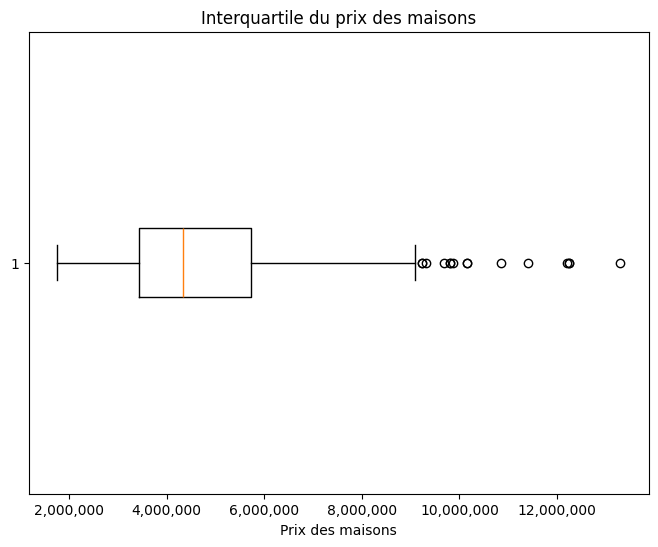

In [137]:
plt.figure(figsize=(8, 6))
plt.boxplot(data['price'].values, vert=False, showfliers=True)

# Configureration sans notation scientifique
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.xlabel('Prix des maisons')
plt.title('Interquartile du prix des maisons')
plt.show()

Cette boite à moustache nous montre facilement dans quel tranche de prix se trouvent les maisons du dataset. Il s'agit de maison très cher qui valent plusieurs millions. Il est alors plus simple pour notre lecture des valeurs de simplifier le prix afin de faciliter l'affichage des graphiques et la manipulation des données. Pour cela nous allons simplement diviser les valeurs par 1 million.

In [138]:
data['price'] = data['price'] / 1000000

De plus la superficie des habitacions semblent être incohérente avec les prix donnés, le dataset provenant des US il est fort probable qu'il s'agisse de valeurs en pied. Pour faciliter la lecture à des non-avertis nous simplifions ces valeurs en mètre carré.

In [139]:
data['area'] = data['area'] / 10.764

In [140]:
data.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

On en profite pour modifier correctement la valeur des colonnes pour qu'elles correspondent à nos modifications. Également nous pouvons traduire ces colonnes en français.

In [141]:
data.rename(columns={
            'price': 'prix(million)', 
            'area': 'air(m2)',
            'bedrooms' : 'chambres',
            'bathrooms' : 'sdb',
            'stories' : 'étages',
            'mainroad' : 'route principale',
            'guestroom' : 'chambre ami',
            'basement' : 'sous sol',
            'hotwaterheating' : 'chauffage au gaz',
            'airconditioning' : 'climatisation',
            'parking' : 'parking',
            'prefarea' : 'résidentiel',
            'furnishingstatus' : 'meublé',
            }, inplace=True)


In [142]:
data.describe()

,prix(million),air(m2),chambres,sdb,étages,parking
count,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729,478.496961,2.965138,1.286239,1.805505,0.693578
std,1.870440,201.611020,0.738064,0.502470,0.867492,0.861586
min,1.750000,153.288740,1.000000,1.000000,1.000000,0.000000
25%,3.430000,334.448161,2.000000,1.000000,1.000000,0.000000
50%,4.340000,427.350427,3.000000,1.000000,2.000000,0.000000
75%,5.740000,590.858417,3.000000,2.000000,2.000000,1.000000
max,13.300000,1505.016722,6.000000,4.000000,4.000000,3.000000


In [143]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   prix(million)     545 non-null    float64
 1   air(m2)           545 non-null    float64
 2   chambres          545 non-null    int64  
 3   sdb               545 non-null    int64  
 4   étages            545 non-null    int64  
 5   route principale  545 non-null    object 
 6   chambre ami       545 non-null    object 
 7   sous sol          545 non-null    object 
 8   chauffage au gaz  545 non-null    object 
 9   climatisation     545 non-null    object 
 10  parking           545 non-null    int64  
 11  résidentiel       545 non-null    object 
 12  meublé            545 non-null    object 
dtypes: float64(2), int64(4), object(7)
memory usage: 55.5+ KB


On vérifie si il y a des valeurs de maison dupliqué.

In [144]:
data.loc[data.duplicated()]

,prix(million),air(m2),chambres,sdb,étages,route principale,chambre ami,sous sol,chauffage au gaz,climatisation,parking,résidentiel,meublé


Aucun valeur ne semble manquante. Nous allons commencer notre analyse.

In [145]:
data.isna().sum()

prix(million)       0
air(m2)             0
chambres            0
sdb                 0
étages              0
route principale    0
chambre ami         0
sous sol            0
chauffage au gaz    0
climatisation       0
parking             0
résidentiel         0
meublé              0
dtype: int64

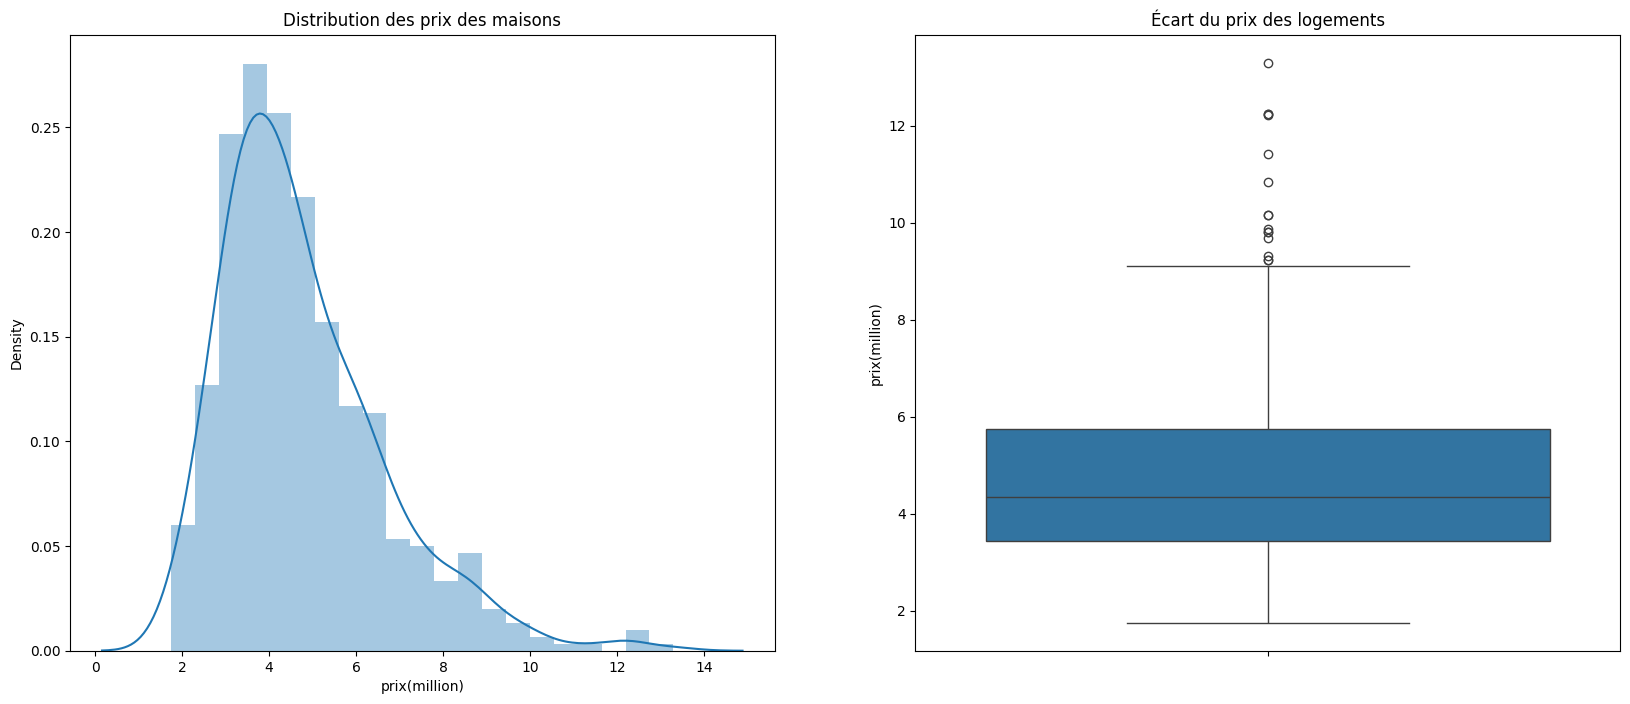

In [146]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Distribution des prix des maisons')
sns.distplot(data['prix(million)'])

plt.subplot(1,2,2)
sns.boxplot(data['prix(million)'])
plt.title('Écart du prix des logements')

plt.show()

In [147]:
print(data['prix(million)'].describe(percentiles = [0.25,0.50,0.75,0.85,0.90,1]))

count    545.000000
mean       4.766729
std        1.870440
min        1.750000
25%        3.430000
50%        4.340000
75%        5.740000
85%        6.615000
90%        7.350000
100%      13.300000
max       13.300000
Name: prix(million), dtype: float64


In [148]:
categorical_list = [x for x in data.columns if data[x].dtype =='object']

Nous identifions les caractéristiques des propriétés qui sont des catégories.

In [149]:
for x in categorical_list: print(x)

route principale
chambre ami
sous sol
chauffage au gaz
climatisation
résidentiel
meublé


On termine notre traduction du dataset par le remplacement des valeurs de catégories.

In [150]:
data.replace("yes", "oui", inplace=True)
data.replace("no", "non", inplace=True)

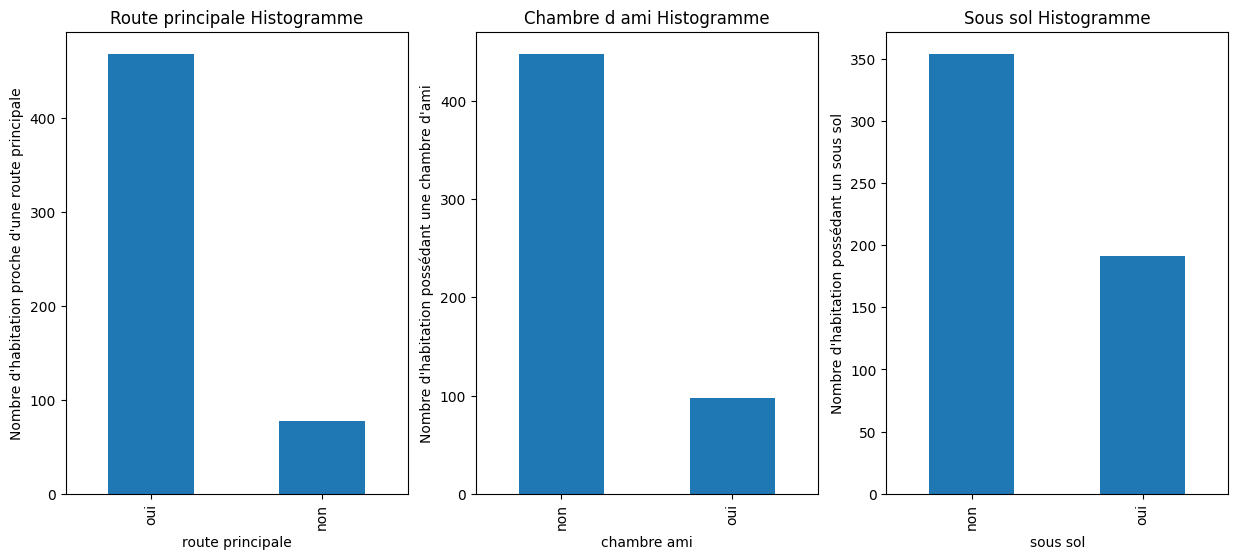

In [151]:
plt.figure(figsize=(15, 6))

plt.subplot(1,3,1)
plt1 = data['route principale'].value_counts().plot(kind='bar')
plt.title('Route principale Histogramme')
plt1.set(xlabel = 'route principale', ylabel="Nombre d'habitation proche d'une route principale")

plt.subplot(1,3,2)
plt1 = data['chambre ami'].value_counts().plot(kind='bar')
plt.title('Chambre d ami Histogramme')
plt1.set(xlabel = 'chambre ami', ylabel="Nombre d'habitation possédant une chambre d'ami")

plt.subplot(1,3,3)
plt1 = data['sous sol'].value_counts().plot(kind='bar')
plt.title('Sous sol Histogramme')
plt1.set(xlabel = 'sous sol', ylabel="Nombre d'habitation possédant un sous sol")

plt.show()

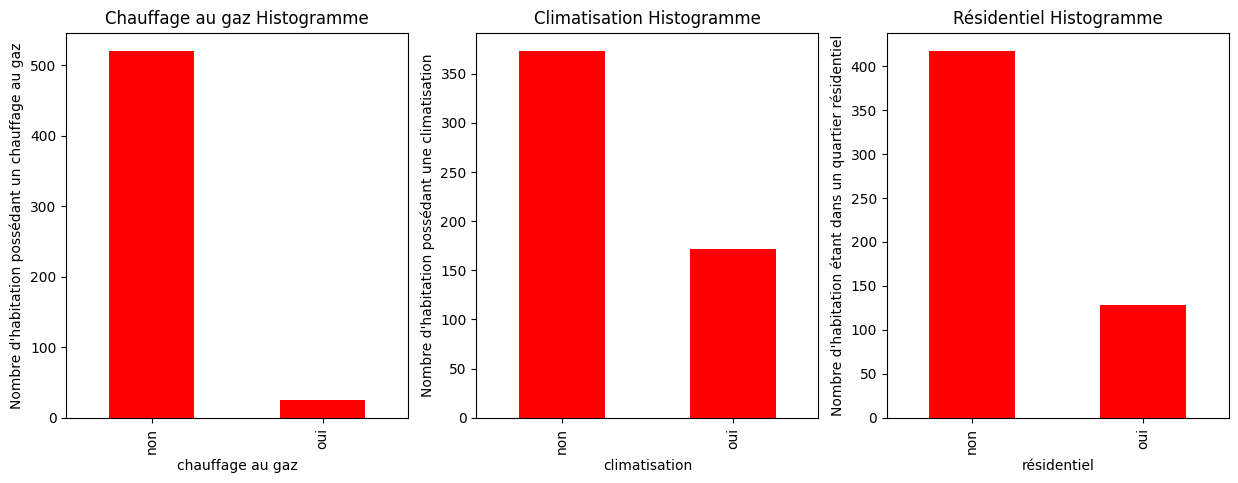

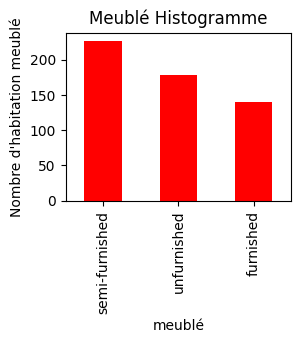

In [152]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt1 = data['chauffage au gaz'].value_counts().plot(kind='bar',color='r')
plt.title('Chauffage au gaz Histogramme')
plt1.set(xlabel = 'chauffage au gaz', ylabel="Nombre d'habitation possédant un chauffage au gaz")

plt.subplot(1, 3, 2)
plt1 = data['climatisation'].value_counts().plot(kind='bar',color='r')
plt.title('Climatisation Histogramme')
plt1.set(xlabel = 'climatisation', ylabel="Nombre d'habitation possédant une climatisation")

plt.subplot(1, 3, 3)
plt1 = data['résidentiel'].value_counts().plot(kind='bar',color='r')
plt.title('Résidentiel Histogramme')
plt1.set(xlabel = 'résidentiel', ylabel="Nombre d'habitation étant dans un quartier résidentiel")
plt.show()

plt.subplot(2, 2, 3)
plt1 = data['meublé'].value_counts().plot(kind='bar',color='r')
plt.title('Meublé Histogramme')
plt1.set(xlabel = 'meublé', ylabel="Nombre d'habitation meublé")
plt.show()

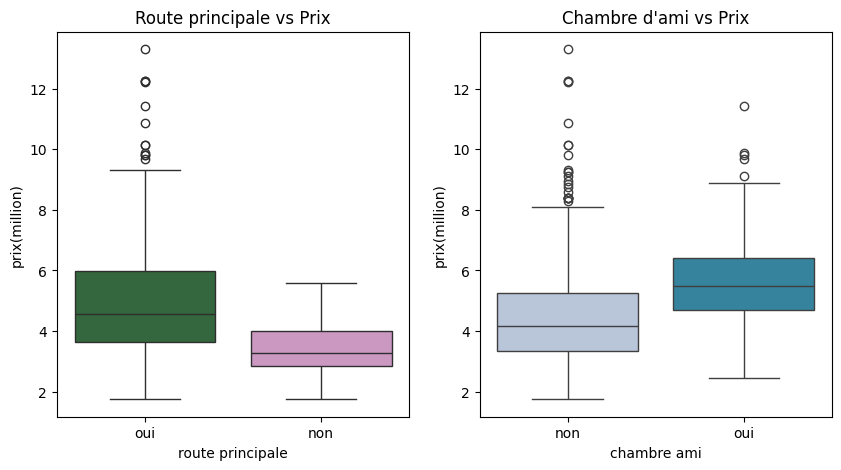

In [153]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Route principale vs Prix')
sns.boxplot(x=data["route principale"], y=data["prix(million)"], palette=("cubehelix"))

plt.subplot(1,2,2)
plt.title("Chambre d'ami vs Prix")
sns.boxplot(x=data["chambre ami"], y=data['prix(million)'], palette=("PuBuGn"))

plt.show()

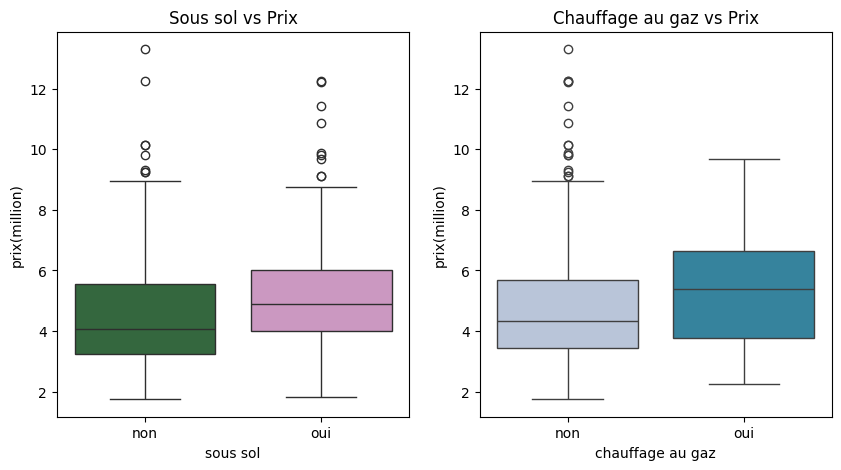

In [154]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Sous sol vs Prix')
sns.boxplot(x=data["sous sol"], y=data["prix(million)"], palette=("cubehelix"))

plt.subplot(1,2,2)
plt.title('Chauffage au gaz vs Prix')
sns.boxplot(x=data["chauffage au gaz"], y=data["prix(million)"], palette=("PuBuGn"))

plt.show()

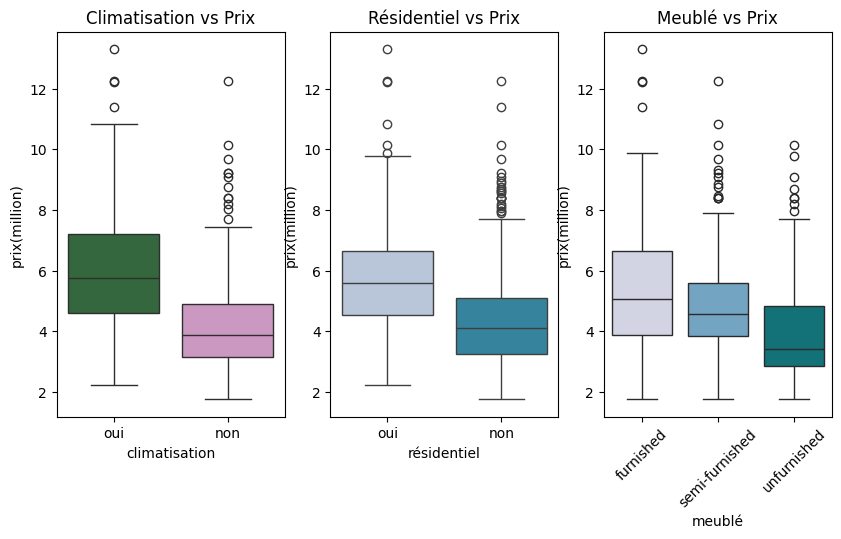

In [155]:
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
plt.title('Climatisation vs Prix')
sns.boxplot(x=data["climatisation"], y=data["prix(million)"], palette=("cubehelix"))

plt.subplot(1,3,2)
plt.title('Résidentiel vs Prix')
sns.boxplot(x=data["résidentiel"], y=data["prix(million)"], palette=("PuBuGn"))

plt.subplot(1,3,3)
plt.title('Meublé vs Prix')
sns.boxplot(x=data["meublé"], y=data["prix(million)"], palette=("PuBuGn"))
plt.xticks(rotation=45)

plt.show()

In [156]:
numerical_list = [x for x in data.columns if data[x].dtype in ('int64','float64')]
print(numerical_list)

['prix(million)', 'air(m2)', 'chambres', 'sdb', 'étages', 'parking']


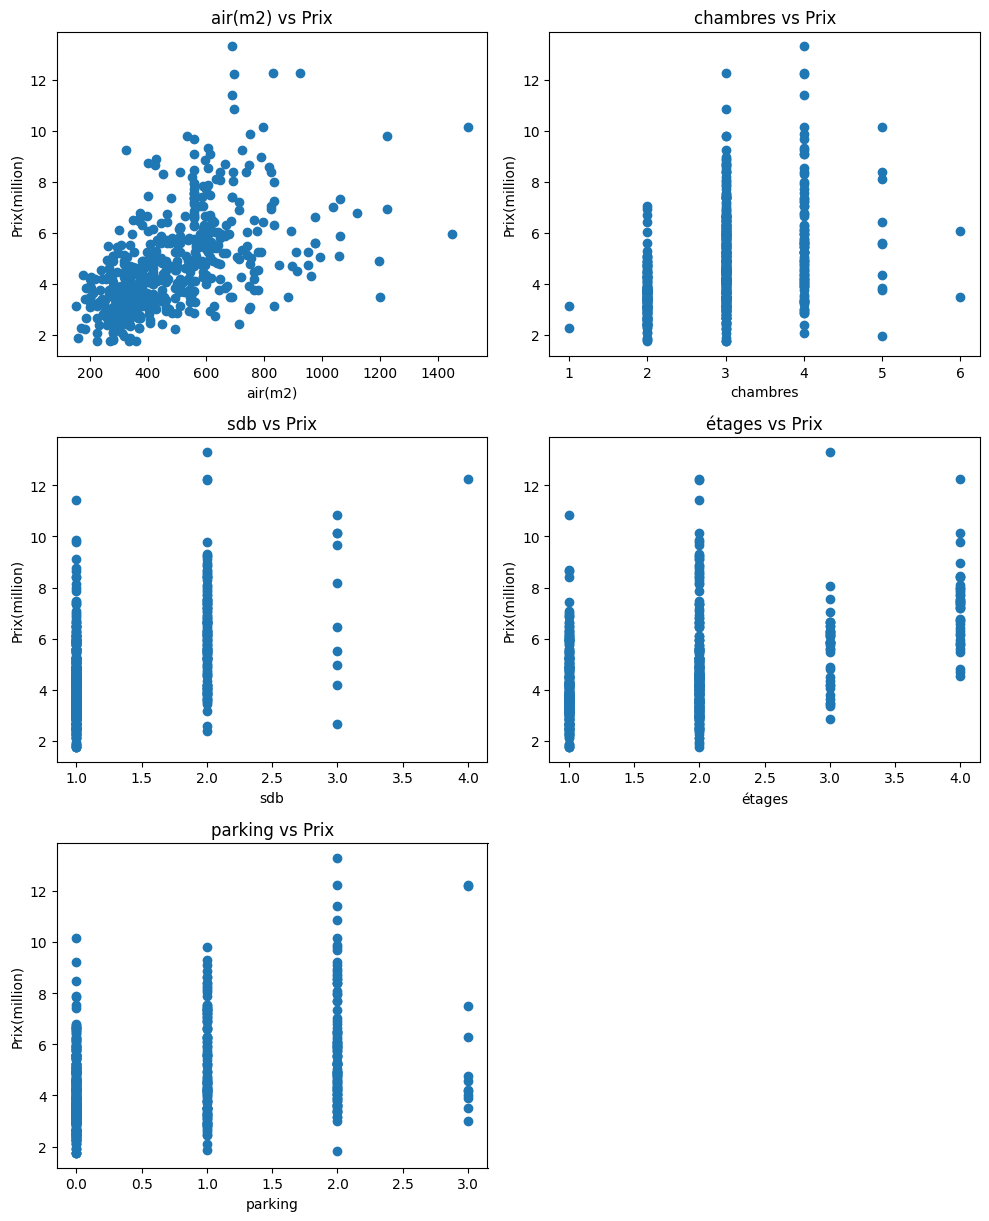

In [157]:
def scatter(x,fig):
    plt.subplot(5,2,fig)
    plt.scatter(data[x],data['prix(million)'])
    plt.title(x+' vs Prix')
    plt.ylabel('Prix(million)')
    plt.xlabel(x)

plt.figure(figsize=(10,20))

scatter('air(m2)', 1)
scatter('chambres', 2)
scatter('sdb', 3)
scatter('étages', 4)
scatter('parking',5)

plt.tight_layout()

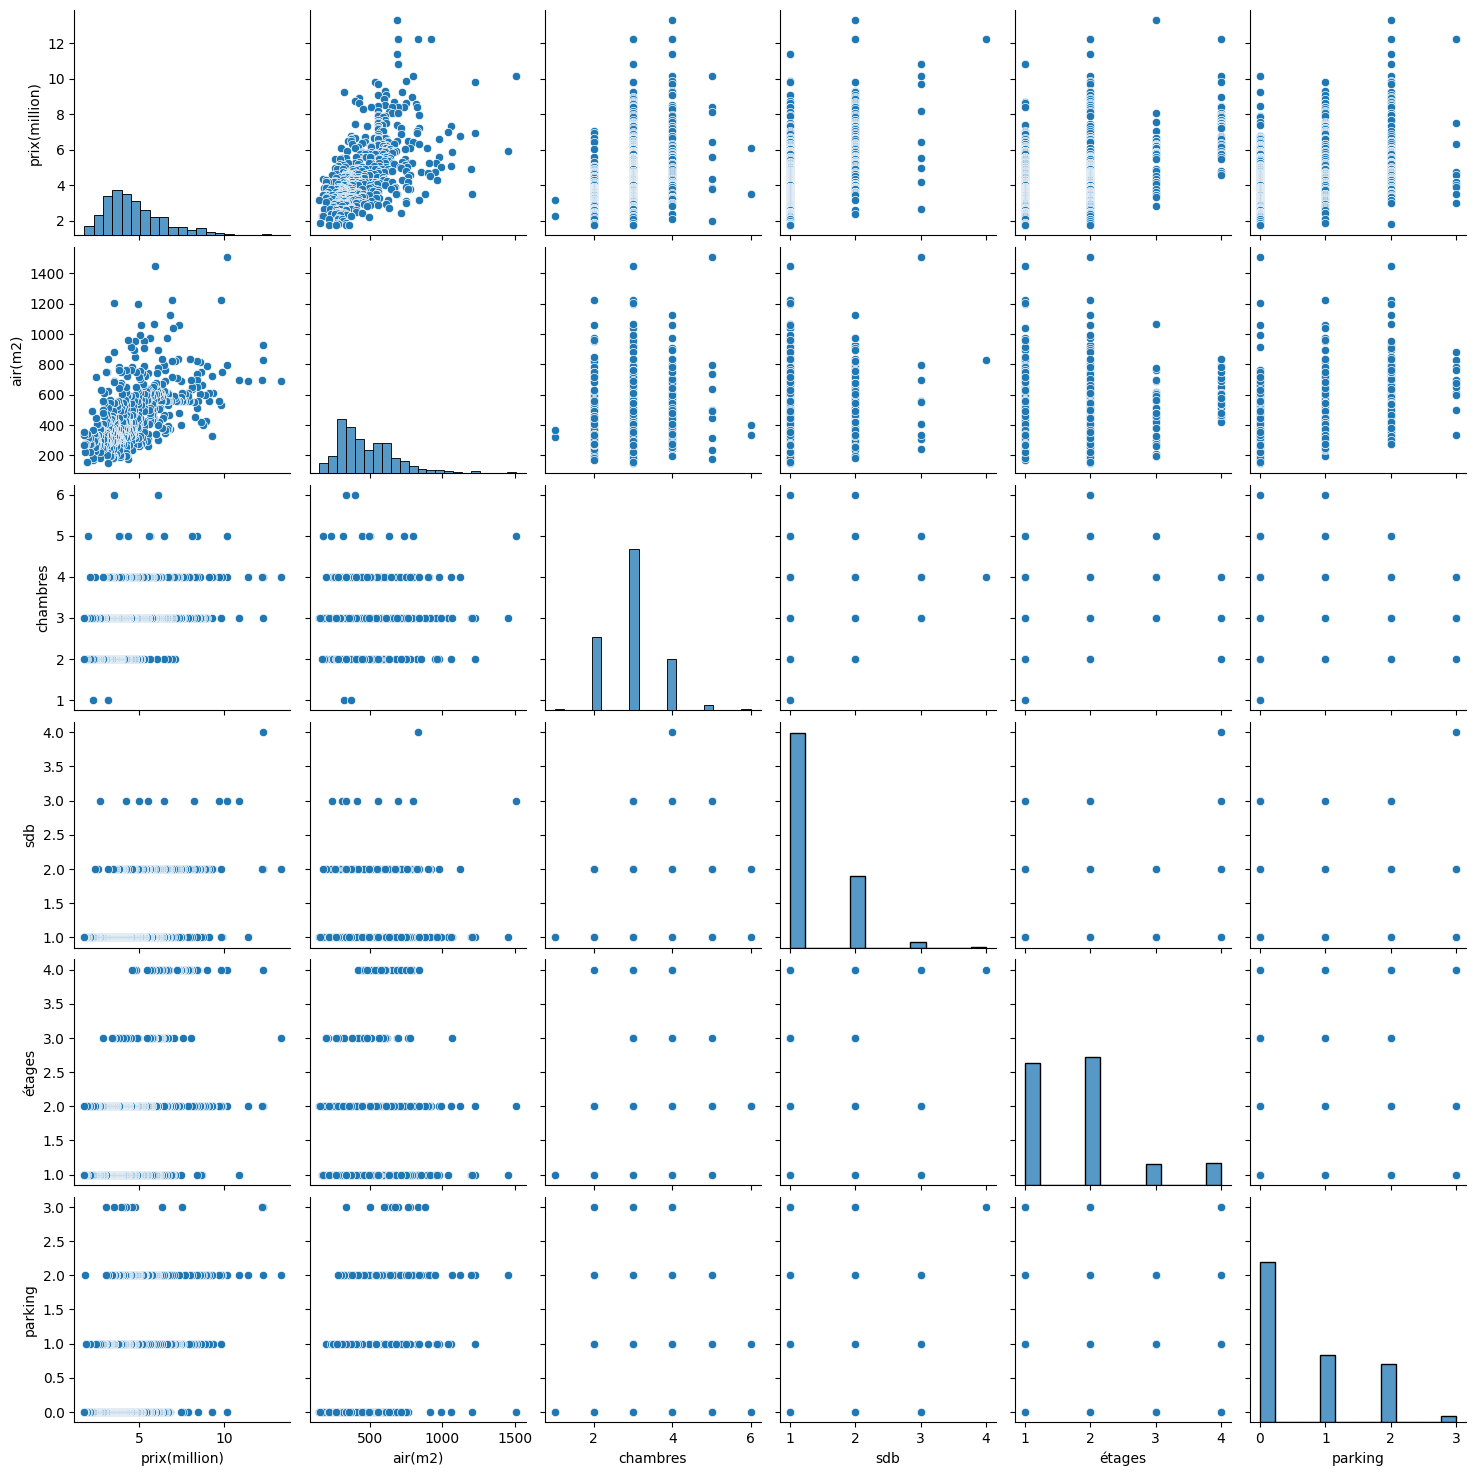

In [158]:
sns.pairplot(data)
plt.show()

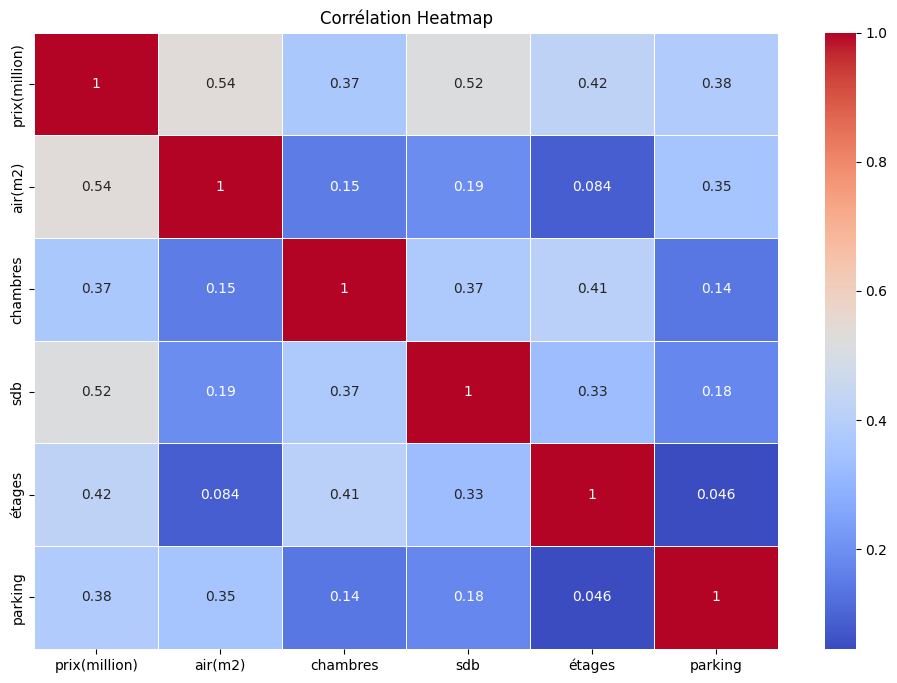

In [159]:
cor_matrix= data[numerical_list].corr()
plt.figure(figsize=(12, 8))  # Set the figure size
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Corrélation Heatmap')
plt.show()

Ce qui intéresse les utilisateurs c'est de pouvoir estimer leurs biens. Nous pouvons facilement constater que le prix est le plus corrélé à la superficie de l'habitation ou au nombre de salle de bain.

In [160]:
for x in categorical_list: print(x)

route principale
chambre ami
sous sol
chauffage au gaz
climatisation
résidentiel
meublé


Nous réaliser une transformation de variable catégorielle en variable numérique par un encodage LabelEncoder(). Cela consiste simplement à transformer les variables caractérisé par des termes en nombre. Ici nous transformerons les non en 0, les oui en 1 les unfurnished en 0, les semi-furnished en 1 et les furnished en 2.

In [161]:
def labelencoder(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            unique_values = df[col].unique()
            if len(unique_values) <= 2:
                df.loc[df[col] == "non", col] = 0
                df.loc[df[col] == "oui", col] = 1
            else:
                df.loc[df[col] == "unfurnished", col] = 0
                df.loc[df[col] == "semi-furnished", col] = 1
                df.loc[df[col] == "furnished", col] = 2
    return df

new_df = labelencoder(data)
new_df

,prix(million),air(m2),chambres,sdb,étages,route principale,chambre ami,sous sol,chauffage au gaz,climatisation,parking,résidentiel,meublé
0,13.30000,689.334820,4,2,3,1,0,0,0,1,2,1,2
1,12.25000,832.404311,4,4,4,1,0,0,0,1,3,0,2
2,12.25000,925.306577,3,2,2,1,0,1,0,0,2,1,1
3,12.21500,696.767001,4,2,2,1,0,1,0,1,3,1,2
4,11.41000,689.334820,4,1,2,1,1,1,0,1,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1.82000,278.706800,2,1,1,1,0,1,0,0,2,0,0
541,1.76715,222.965440,3,1,1,0,0,0,0,0,0,0,1
542,1.75000,336.306206,2,1,1,1,0,0,0,0,0,0,0
543,1.75000,270.345596,3,1,1,0,0,0,0,0,0,0,2
